In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Successive Convexification (Implementation)

Packages required: numpy, cvxpy, matplotlib.


The successive convexification method [1] solves the following optimization problem with convex objective $f$ and non-convex constraints $g$:
$$
\begin{aligned}
\min_{z}\ &f(z) \\
\text{subject to }\
&g(z) = 0, \\
&h(z) \leq 0.
\end{aligned}
$$
by iterating 
$z_{k+1} = z_k + \textrm{update}(z_k)$
for $k=1,\dots,K$
convex subproblems given by
$$
\begin{aligned}
\textrm{update}(z_k) = \arg \min_{\delta z, \delta g, \delta h}\ &f(z_k + \delta z) + \textrm{penalty}(\delta g, \delta h^+) + \textrm{trust_region}(\tau) \\
\text{subject to }
& Dg(z_k)(z_k-\delta z) = \delta g, \\
& Dh(z_k)(z_k-\delta z) \leq \delta h, \\
& \|\delta z\| \leq \tau.
\end{aligned}
$$

For optimal control problems, we use $z = (x,u)$ to represent the state and controls of the vehicle. The non-convex constraints are set up as follows:
* the equality constraint $g$ typically describes the dynamics $\dot x = F(x,u),\ x(0)=x_0,\ x(t_f) = x_N$ but discretized;
* the inequality constraint $h$ typically describes safe state and control sets.

[1] Szmuk, M., Acikmese, B., & Berning, A. W. (2016). Successive Convexification for Fuel-Optimal Powered Landing with Aerodynamic Drag and Non-Convex Constraints. AIAA Guidance, Navigation, and Control Conference. doi:10.2514/6.2016-0378 

In [2]:
""" Plot helpers """
def init_plot(figsize):
    fig, ax = plt.subplots(figsize=figsize)
    return ax
  
def plot_environment(ax, x_init, x_des, r_obs, R_obs, clearance, waypoints):
    ax.plot(*x_des[:2],'^',label='destination')
    ax.plot(*x_init[:2],'*',label='initial')
    _t = np.linspace(0,2*np.pi,25)
    for r,R in zip(r_obs, R_obs):
        ax.add_artist(plt.Circle(r, R, color='k', alpha=1))
        ax.plot(np.cos(_t)*(R+clearance)+r[0], np.sin(_t)*(R+clearance)+r[1], ':k')
    for k in waypoints:
        ax.plot(*waypoints[k], 'Db', markersize=10, mfc='none')
    ax.set(xlim=[-1.1,1.1], ylim=[-1.1,1.1])
    return ax

def plot_trajectory(ax, x, **kwargs):
    ax.plot(x[:,0], x[:,1], 'o-', ms=5, **kwargs)

**Example: Point mass in 2D with circle obstacles and waypoints**

In [3]:
def cvx(problem, solver='SCS'):
    """ Convex problem used to initialize scvx
        using linear dynamics and ignoring obstacles
    """
    size, setup = problem
    N, (nx, nu), *_ = size
    (f, Df), (g, (Dxg, Dug)), _, waypoints = setup
    
    x = cp.Variable((N,nx))
    u = cp.Variable((N,nu))
    
    A = cp.Parameter((nx,nx))
    B = cp.Parameter((nx,nu))
    x_init = cp.Parameter(nx)
    x_des = cp.Parameter(nx)
    w = {k:cp.Parameter(2) for k in waypoints}
    
    cost = cp.norm(u)**2
    dynamics = [x[i+1] == A@x[i] + B@u[i] for i in range(N-1)]
    dynamics += [x[0] == x_init, 
                 x[-1] == x_des]
    dynamics += [x[k,:2] == w[k] for k in waypoints]
    
    def init():
        opt = cp.Problem(cp.Minimize(cost), dynamics)
        return opt
      
    def update(opt, parameters):
        vehicle, boundary, waypoints = parameters
        A.value = Dxg(None, None)
        B.value = Dug(None, None)
        x_init.value, x_des.value = boundary
        for k in waypoints:
            w[k].value = waypoints[k]
        
        cost = opt.solve(solver=solver)
        return opt, cost
      
    def get(opt):
        return x.value, u.value
      
    return init, update, get

Iteration 0000


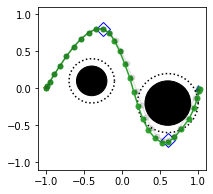

('optimal_inaccurate', 4113.8340061767485, array(10.79520329))
Iteration 0001


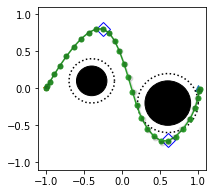

('optimal_inaccurate', 1322.7392181546193, array(2.79746363))
Iteration 0002


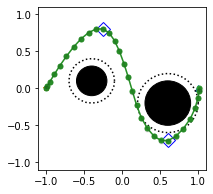

('optimal_inaccurate', 908.6675061200958, array(0.7297378))
Iteration 0003


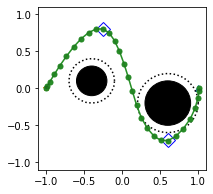

('optimal', 821.1531345363298, array(0.06591473))
Iteration 0004


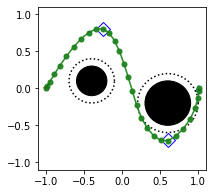

('optimal_inaccurate', 818.5613279396296, array(0.02942899))


In [4]:
def scvx(problem, weights, solver='SCS'):
    """ Successive Convexification of an optimal control problem
        
    Solves 
    
        min f(z)
         z
        s.t g(z) == 0
            h(z) <= 0
            
    for z=(x,u) by successively solving a linearized subproblem,
    
        min f(z+dz) + penality(dg, dh+) + trust(tau)
         dz
        s.t. Dg(z)(z+dz) == dg
             Dh(z)(z+dz) <= dh
             dh >= 00
             \|dz\| <= tau
             
    where dg, dh are slack variables and tau is the trust region.
    
    """
    size, setup = problem
    N, nz, ng, nh = size
    (f, Df), (g, Dg), (h, Dh), waypoints = setup
    
    nx, nu = nz
    Dxg, Dug = Dg
    Dxh, Duh = Dh
    G = np.eye(ng) # Virtual force allowed on all states
    
    ''' Operating point '''
    x = cp.Parameter((N, nx))
    u = cp.Parameter((N, nu))
    
    ''' Linear extrapolation '''
    dx = cp.Variable((N, nx))
    du = cp.Variable((N, nu))
    dg = cp.Variable((N, ng))
    dh = cp.Variable((N, nh))
    trust = cp.Variable()
    
    ''' Boundary conditions '''
    x0 = cp.Parameter(nx)
    xN = cp.Parameter(nx)
    
    ''' Waypoints '''
    w = {k:cp.Parameter(2) for k in waypoints}
    
    ''' Linearizations '''
    Gx = [cp.Parameter((nx, nx)) for _ in range(N)]
    Gu = [cp.Parameter((nx, nu)) for _ in range(N)] 
    Hx = [cp.Parameter((nh, nx)) for _ in range(N)]
    Hu = [cp.Parameter((nh, nu)) for _ in range(N)]
    g_eval = [cp.Parameter(ng) for _ in range(N)]
    h_eval = [cp.Parameter(nh) for _ in range(N)]
    
    variables = (dx, du, dg, dh)
    linearization = (Gx, Gu, Hx, Hu, g_eval, h_eval)
    parameters = (x, u, trust)

    ''' Objective '''
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])
    objective =  weights['cost']*f(x+dx, u+du) 
    objective += weights['penalty']*cp.sum(cp.abs(dg)) 
    objective += weights['penalty']*cp.sum(cp.pos(dh))
    objective += weights['trust']*trust
    objective += weights['relax_x0']*cp.norm(x[0] + dx[0] - x0)
    objective += weights['relax_xk']*sum([cp.norm(T@(x[k] + dx[k]) - w[k]) 
                                          for k in waypoints])
    objective += weights['relax_xN']*cp.norm(x[-1] + dx[-1] - xN)

    ''' Linearized Constraints '''
    constraints = [x[i+1] + dx[i+1] - (Gx[i]@dx[i] + Gu[i]@du[i] + g_eval[i]) == G@dg[i]
                    for i in range(N-1)]
    constraints += [Hx[i]@dx[i] + Hu[i]@du[i] + h_eval[i] <= dh[i] 
                    for i in range(N)]
    constraints += [sum([cp.norm(dx[i],2) + cp.norm(du[i],2) 
                         for i in range(N)]) <= trust ]
#     constraints += [cp.abs(u) <= u_max]
    constraints += [dh >= 0]

    def init(initialize=None):
        if initialize is None: 
            state, action = np.zeros((N,nx)), np.zeros((N,nu))
        else:
            state, action = initialize
        socp = cp.Problem(cp.Minimize(objective), constraints)
        return socp, (state, action)

    def update(opt, parameters):
        socp, (state, action) = opt
        vehicle, boundary, obstacles, waypoints = parameters 
        
        ''' Set boundary and waypoint conditions '''
        x.value, u.value = state, action
        x0.value, xN.value = boundary
        for k in waypoints:
            w[k].value = waypoints[k]
        
        ''' Linearize dynamics and constraints '''
        for i in range(N):
            Gx[i].value = Dxg(x.value[i], u.value[i])
            Gu[i].value = Dug(x.value[i], u.value[i])
            Hx[i].value = Dxh(x.value[i], u.value[i], *obstacles[i])
            Hu[i].value = Duh(x.value[i], u.value[i])
            g_eval[i].value = g(x.value[i],u.value[i])
            h_eval[i].value = h(x.value[i], u.value[i], *obstacles[i])
        
        ''' Solve SOCP '''
        socp.solve(solver=solver, warm_start=True)
        
        ''' Return state of optimizer and iteration info '''
        opt = (socp, (x.value+dx.value, u.value+du.value))
        info = (socp.status, objective.value, trust.value)
        return opt, info
               
    def get(opt):
        return (objective, constraints), (variables, parameters), linearization
        
    return init, update, get

""" User settings"""
save_dir = None #'figs/scvx/'

""" Time Setup """
time_duration, time_discretization = 3, 30

dt = time_duration/time_discretization
N = time_discretization 

""" Environment Setup """
# Obstacles
obstacle_pos = [[-0.4, 0.1], [ 0.6, -0.2]]
obstacle_radius = [0.2, 0.3]
drone_clearance = .1

# Waypoints
x_init = np.array([-1,0,0,0])
x_des  = np.array([1,0,0,0])
waypoints = {int(N/3): [-.25,.8], 
             int(3*N/4): [.6,-.7]}
# waypoints = {} # Dont use waypoints
boundary = (x_init, x_des)

""" Vehicle Setup """
# Double integrator
dim = 2
A = np.block([[np.eye(dim), dt * np.eye(dim)],
              [np.zeros((dim,dim)), np.eye(dim)]])
B = np.block([[0.5*dt**2 * np.eye(dim)], 
              [dt*np.eye(dim)]])

""" Configure SCVX """
scvx_weights = dict(cost = 1e-1,
                    trust = 1e2, 
                    penalty = 1e4, 
                    relax_x0 = 1e4,
                    relax_xk = 1e4,
                    relax_xN = 1e4)
use_interpolated_initialiazation = True
num_iter = 5

nx = A.shape[0] # Number of states per agent
nu = B.shape[1] # Number of actions per agent
ng = nx # Number of equality constraints per i=1...N
nh = len(obstacle_pos) # Number of inequality constraints per i=1...N

problem_size = (N, (nx, nu), ng, nh)

def minimum_fuel():
    R = np.eye(dim)
    def cost(x,u): return cp.sum([cp.quad_form(_, R) for _ in u])
    def Dcost(x,u): raise NotImplemented("Deriatives not implemented")
    return cost, (Dcost, Dcost)
  
def linear_dynamics(A,B):
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]
    def F(x,u): 
        return A@x + B@u
    def DxF(x,u): 
        return A
    def DuF(x,u): 
        return B
    return F, (DxF, DuF)
  
def cylinders(position, radius, clearance):
    # Projection
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])
    def h(x,u,pos=position,rad=radius): 
        return np.block([(R+clearance)**2 - np.linalg.norm(r - T@x)**2
                         for r,R in zip(pos, rad)])
    def Dxh(x,u,pos=position,rad=radius):
        return np.block([[2*T.T@(r - T@x)]
                         for r,R in zip(pos, rad)])
    def Duh(x,u):
        return np.zeros((nh,nu))
    return h, (Dxh, Duh)

""" Problem setup """
vehicle = (minimum_fuel(), \
           linear_dynamics(A,B), \
           cylinders(obstacle_pos, obstacle_radius, clearance=drone_clearance),\
           waypoints)
obstacles_timevaring = [(obstacle_pos, obstacle_radius) for _ in range(N)]
parameters = (vehicle, boundary, obstacles_timevaring, waypoints)
problem = (problem_size, vehicle)

""" Use interpolation as initialization """
interpolation = None
if use_interpolated_initialiazation:
    cvx_init, cvx_update, cvx_get = cvx(problem)
    interpolation = cvx_get(cvx_update(cvx_init(), (vehicle, boundary, waypoints))[0])

""" Initialize successive convexification """
scvx_init, scvx_update, scvx_get = scvx(problem, scvx_weights)
opt = scvx_init(initialize=interpolation)

""" Plot function """
def plot(opt, parameters, save=(None,-1)):
    _,((d,*_),(x,*_)),_ = scvx_get(opt)
    _, (x_init,x_des), obstacles, waypoints = parameters
    r_obs, R_obs = obstacles[0]
    ax = init_plot(figsize=(3,3))
    ax = plot_environment(ax, x_init, x_des, r_obs, R_obs, drone_clearance, waypoints)
    plot_trajectory(ax, x.value+d.value)
    plot_trajectory(ax, x.value, color='k', alpha=0.1)
    if save[0] is not None:
        plt.savefig(("{}scvx{:04d}.png").format(*save))
    plt.show()
    
""" Run SCVX """
for i in range(num_iter):
    print("Iteration {:04d}".format(i))
    opt, info = scvx_update(opt, parameters)
    plot(opt, parameters, save=(save_dir, i))
    print(info)

In [5]:
!convert -delay 40 -loop 0 'figs/scvx/scvx0*.png' scvx_stable.gif